<a href="https://colab.research.google.com/github/basilsaju383/Deep-Learning-Projects/blob/main/keras_Tuner_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error

In [4]:
df = pd.read_excel('/content/sample_data/mc4 GSM 3 month.xlsx')
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df[['DateTime', 'RSSI']]
df = df.dropna()

In [5]:
timestamps = df['DateTime']

# Use both Temperature and Humidity columns
data = df[['RSSI']].values

# Normalize the data to the range [0, 1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert timestamps to Unix timestamps
unix_timestamps = timestamps.astype(np.int64) // 10**9  # Convert nanoseconds to seconds

# Concatenate Unix timestamps with the normalized data
data_with_timestamps = np.concatenate((unix_timestamps.values.reshape(-1, 1), data_scaled), axis=1)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data_with_timestamps, test_size=0.2, random_state=42)



In [6]:
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length, 0]  # Temperature is the target variable
        X.append(seq)
    return np.array(X)
# Define the sequence length
seq_length = 10

# Create sequences for training and testing for both temperature and humidity
X_train = create_sequences(train_data[:, 1:], seq_length)  # Exclude timestamps for input data
X_test = create_sequences(test_data[:, 1:], seq_length)

In [7]:
X_train.shape,X_test.shape

((3713, 10, 1), (921, 10, 1))

In [8]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [17]:
import keras
from keras import layers
import tensorflow as tf
import keras_tuner

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 10)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh", "sigmoid"]),
            )
        )

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))

    model.add(layers.Dense(10, activation=hp.Choice("output_activation", ["relu", "tanh", "sigmoid"])))

    optimizer_name = hp.Choice("optimizer", values=["adam", "adadelta", "sgd", "rmsprop"])
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    # Create an instance of the selected optimizer
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "adadelta":
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Invalid optimizer name")

    model.compile(
        optimizer=optimizer,
        loss="mae",
        metrics=["mae"],
    )

    return model

# Example usage
build_model(keras_tuner.HyperParameters())


In [25]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
)

Reloading Tuner from ./untitled_project/tuner0.json


In [26]:
tuner.search_space_summary()

Search space summary
Default search space size: 12
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
output_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'adadelta', 'sgd', 'rmsprop'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'mi

In [27]:
tuner.search(X_train, X_train, epochs=5, validation_data=(X_test, X_test))

In [28]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
num_layers: 5
units_0: 256
activation: tanh
dropout: False
output_activation: sigmoid
optimizer: adadelta
lr: 0.00020422632013227844
units_1: 320
units_2: 320
units_3: 416
units_4: 160
units_5: 384
Score: 0.4458969533443451

Trial 1 summary
Hyperparameters:
num_layers: 1
units_0: 64
activation: tanh
dropout: True
output_activation: relu
optimizer: rmsprop
lr: 0.004226349752062374
units_1: 288
units_2: 416
units_3: 64
units_4: 160
units_5: 96
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)


In [29]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 5,
 'units_0': 256,
 'activation': 'tanh',
 'dropout': False,
 'output_activation': 'sigmoid',
 'optimizer': 'adadelta',
 'lr': 0.00020422632013227844,
 'units_1': 320,
 'units_2': 320,
 'units_3': 416,
 'units_4': 160,
 'units_5': 384}

In [30]:
model = tuner.get_best_models(num_models=1)[0]

In [31]:
history = model.fit(X_train, X_train ,epochs=500, initial_epoch=5, validation_data=(X_test,X_test))

Epoch 6/500
117/117 [==============================] - 3s 18ms/step - loss: 0.4454 - mae: 0.4454 - val_loss: 0.4454 - val_mae: 0.4454
Epoch 7/500
117/117 [==============================] - 1s 12ms/step - loss: 0.4449 - mae: 0.4449 - val_loss: 0.4448 - val_mae: 0.4448
Epoch 8/500
117/117 [==============================] - 1s 9ms/step - loss: 0.4443 - mae: 0.4443 - val_loss: 0.4443 - val_mae: 0.4443
Epoch 9/500
117/117 [==============================] - 1s 11ms/step - loss: 0.4437 - mae: 0.4437 - val_loss: 0.4437 - val_mae: 0.4437
Epoch 10/500
117/117 [==============================] - 1s 12ms/step - loss: 0.4431 - mae: 0.4431 - val_loss: 0.4431 - val_mae: 0.4431
Epoch 11/500
117/117 [==============================] - 1s 10ms/step - loss: 0.4425 - mae: 0.4425 - val_loss: 0.4424 - val_mae: 0.4424
Epoch 12/500
117/117 [==============================] - 1s 10ms/step - loss: 0.4419 - mae: 0.4419 - val_loss: 0.4418 - val_mae: 0.4418
Epoch 13/500
117/117 [==============================] - 1s 1

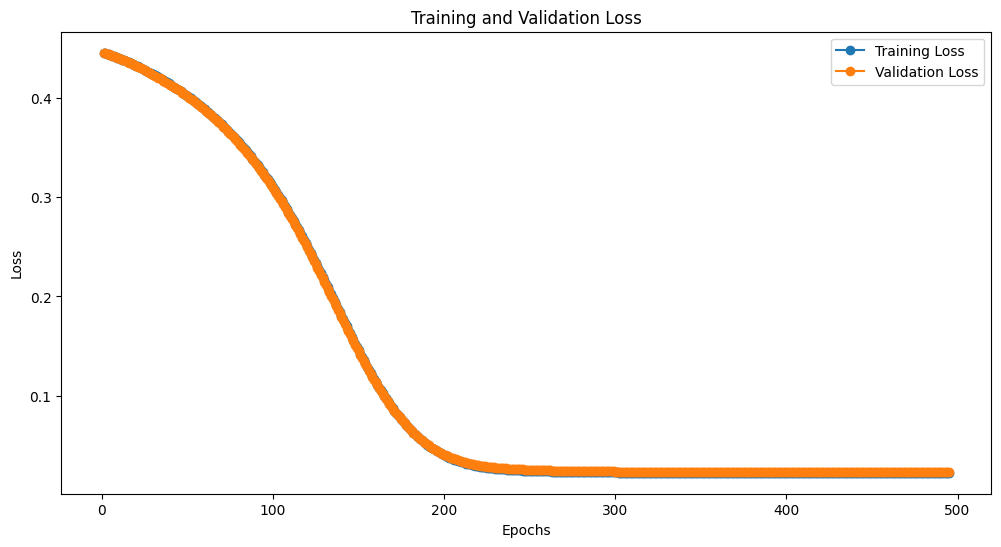

In [32]:
import matplotlib.pyplot as plt
# Extract data from the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)
# Plotting
plt.figure(figsize=(12, 6))
# Plot training and validation loss
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Display the plot
plt.show()